In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC

from post_LED_censor_utils import rho_A_t_fn, cum_A_t_fn, CDF_rho_times_P_x_t_fn, CDF_v_change_till_stim_trunc_adj_fn, PDF_t_v_change
from scipy.integrate import trapezoid as trapz

# data

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# drop rows from df where intended_fix, LED_onset_time and timed_fix are nan
df = df.dropna(subset=['intended_fix', 'LED_onset_time', 'timed_fix'])
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))

# VBMC

In [3]:
T_trunc = 0.3

In [24]:
def compute_loglike(row, base_V_A, theta_A, t_A_aff):
    t_stim = row['intended_fix']
    rt = row['timed_fix']
    t_led = row['intended_fix'] - row['LED_onset_time']
    is_led_trial = row['LED_trial']

    trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, base_V_A, theta_A)

    if rt <= T_trunc:
        likelihood = 0
    else:
        if is_led_trial:
            if t_led == 0:
                likelihood = 1
            else:
                if t_led < T_trunc:
                    likelihood = 1
                else:
                    if rt < t_led:
                        likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A) / trunc_factor
                    else:
                        likelihood = (1 - cum_A_t_fn(t_led - t_A_aff, base_V_A, theta_A)) / trunc_factor
        else:
            if t_stim < T_trunc:
                likelihood = 1
            else:
                if rt < t_stim:
                    likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A) / trunc_factor
                else:
                    likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff, base_V_A, theta_A)) / trunc_factor
    
        

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    base_V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, base_V_A, theta_A, t_A_aff)\
                                                    for _, row in df.iterrows())
                                        
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [25]:
base_V_A_bounds = [0.1, 5]
theta_A_bounds = [0.5, 5]
t_A_aff_bounds = [-2, 0.09]

base_V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [1, 3]
t_A_aff_plausible_bounds = [0, 0.06]

# prior

In [26]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    base_V_A, theta_A, t_A_aff = params

    base_V_A_logpdf = trapezoidal_logpdf(base_V_A, base_V_A_bounds[0], base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1], base_V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return base_V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [27]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [28]:
lb = [base_V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [base_V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]

plb = [base_V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [base_V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
base_V_A_0 = np.random.uniform(base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([base_V_A_0, theta_A_0, t_A_aff_0])

In [ ]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

In [ ]:
vp.save('post_led_censor_test_vbmc.pkl')

In [4]:
import pickle
with open('post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

# corner plot

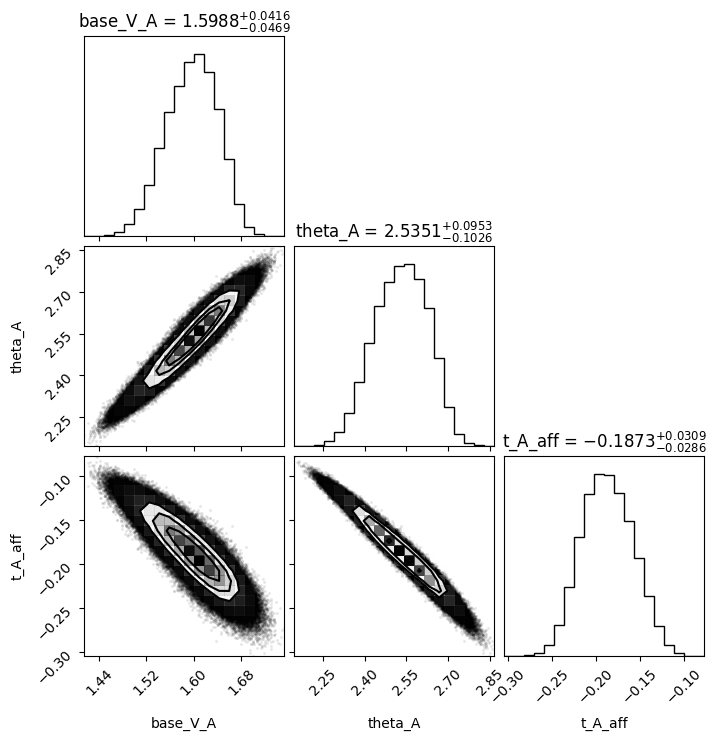

In [5]:
import corner
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");


In [6]:
# from tqdm import tqdm
base_V_A_mean = np.mean(base_V_A_samp)
t_A_aff_mean = np.mean(t_A_aff_samp)
theta_A_mean = np.mean(theta_A_samp)

# compare curves with different post led values

In [ ]:
############################ THEORY CURVES ARE WRONG ##############################################
# N_sample = 1000
# df_sample = df.sample(N_sample)

# dt = 0.1; T_max = 1.5
# t_pts = np.arange(-2, 2, dt)
# pdf_n_led_on = np.zeros((N_sample, len(t_pts)))

# trunc_factor_pre_led = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)

# for i, (_, row) in enumerate(tqdm(df_sample.iterrows(), total=len(df_sample))):
#     t_stim = row['intended_fix']
#     t_led = row['intended_fix'] - row['LED_onset_time']

#     trunc_factor_post_led = 1 - CDF_rho_times_P_x_t_fn(T_trunc, t_led,  base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean)
#     for ti, t in enumerate(t_pts):
#         t_prime = t + t_led
#         if t_prime <= T_trunc:
#             pdf_n_led_on[i, ti] = 0
#         else:
#             if t_led == 0 and t_prime < t_stim:
#                 pdf_n_led_on[i, ti] = rho_A_t_fn(t_prime - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_pre_led
#             elif t_prime > t_stim:
#                 pdf_n_led_on[i, ti] = 0
#             else:
#                 if t <= t_led and t < t_stim:
#                     pdf_n_led_on[i, ti] = rho_A_t_fn(t_prime - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_pre_led
#                 elif t > t_led and t < t_stim:
#                     pdf_n_led_on[i, ti] = PDF_t_v_change(t_prime, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean) / trunc_factor_post_led
#                 elif t > t_stim:
#                     pdf_n_led_on[i, ti] = 0


In [7]:
# data LED ON and LED OFF 

df_led_on_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]
df_led_off_aborts = df[ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > T_trunc) ]


led_on_aborts_wrt_led = df_led_on_aborts['timed_fix'] - (df_led_on_aborts['intended_fix'] - df_led_on_aborts['LED_onset_time'])
led_off_aborts_wrt_led = df_led_off_aborts['timed_fix'] - (df_led_off_aborts['intended_fix'] - df_led_off_aborts['LED_onset_time'])

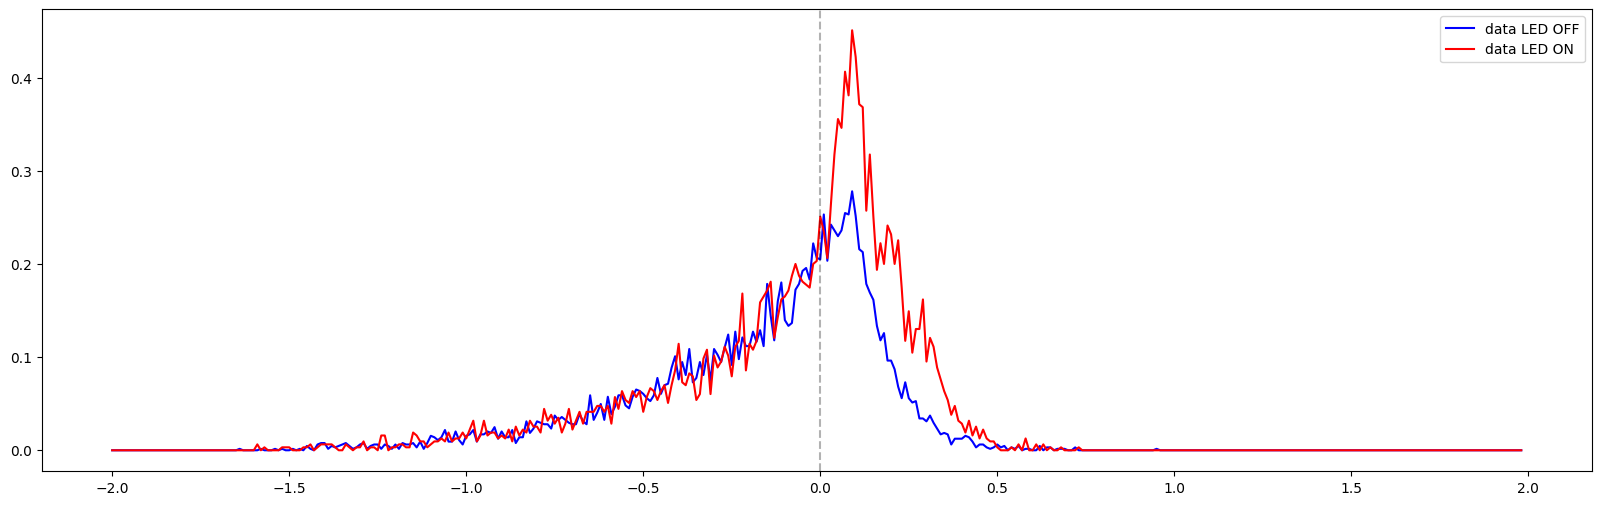

In [9]:
dt_data = 0.01
t_pts_data = np.arange(-2, 2, dt_data)

### OFF ### 
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[ df['LED_trial'] == 0]))


### ON ###
on_hist, _ = np.histogram(led_on_aborts_wrt_led, bins=t_pts_data, density=True)
on_hist *= (len(led_on_aborts_wrt_led) / len(df[ df['LED_trial'] == 1]))

plt.figure(figsize=(20, 6))
plt.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')


plt.legend()
plt.axvline(0, color='k', ls='--', alpha=0.3)

# compare with many new v_a change

In [ ]:
######################################## THEORY PDFs DONT WORK ###############################################
# N_sample = 5000
# df_sample = df.sample(N_sample)

# plt.figure(figsize=(20, 5))

# dt = 0.05; T_max = 1.5
# t_pts = np.arange(-1, 1, dt)

# trunc_factor_pre_led = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
# # steps = np.arange(1, 7, 1)
# # steps = [0]
# # steps = [0, 1, 4, 6, 8]
# steps = [2, 6]
# f = 1
# for step in steps:
#     new_v = base_V_A_mean + step 
#     pdf_n_led_on = np.zeros((N_sample, len(t_pts)))

#     for i, (_, row) in enumerate(tqdm(df_sample.iterrows(), total=len(df_sample))):
#         t_stim = row['intended_fix']
#         t_led = row['intended_fix'] - row['LED_onset_time']

#         trunc_factor_post_led = 1 - CDF_rho_times_P_x_t_fn(T_trunc, t_led,  base_V_A_mean, new_v, theta_A_mean, t_A_aff_mean)
#         for ti, t in enumerate(t_pts):
#             t_prime = t + t_led
#             if t_prime <= T_trunc:
#                 pdf_n_led_on[i, ti] = 0
#             else:
#                 if t_led == 0 and t_prime < t_stim:
#                     pdf_n_led_on[i, ti] = rho_A_t_fn(t_prime - t_A_aff_mean, new_v, theta_A_mean) / trunc_factor_pre_led
#                 elif t_prime > t_stim:
#                     pdf_n_led_on[i, ti] = 0
#                 else:
#                     if t <= t_led and t < t_stim:
#                         pdf_n_led_on[i, ti] = rho_A_t_fn(t_prime - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_pre_led
#                     elif t > t_led and t < t_stim:
#                         pdf_n_led_on[i, ti] = PDF_t_v_change(t_prime, t_led, base_V_A_mean, new_v, theta_A_mean, t_A_aff_mean) / trunc_factor_post_led
#                     elif t > t_stim:
#                         pdf_n_led_on[i, ti] = 0

    
#     pdf_n_led_on_mean = np.mean(pdf_n_led_on, axis=0)
#     plt.subplot(1, len(steps),f)
#     plt.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
#     plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')

#     plt.plot(t_pts, pdf_n_led_on_mean, label=f'theory, drift inc={step:.2f}', ls='--', lw=3)
#     plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
#     plt.xlabel('abort wrt led')
#     plt.ylabel('density')
#     plt.xlim(-1, 0.7)
#     plt.legend()
#     f += 1



# compare with V_A change but simulation, NOT theory

In [15]:
dt = 1e-3; dB = np.sqrt(dt)
def simulate_v_change_pro(sim_params):
    v = sim_params['v']; theta = sim_params['theta']; new_v = sim_params['new_v']; aff = sim_params['aff'] 
    t_led = sim_params['t_led'];
    
    dv = 0
    t = aff - 0.04      
    while True:
        if t > t_led:
            v = new_v
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv > theta:
            return t + 0.04, sim_params
        

def simulate_single_bound(sim_params):
    v = sim_params['v']; theta = sim_params['theta']; aff = sim_params['aff']
    dv = 0; t = 0
    while True:
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv > theta:
            return t + aff, sim_params
        

def filter_sim_res(all_res):
    rts_wrt_led = []
    num_aborts = 0
    for res in all_res:
        rt = res[0]
        params = res[1]

        t_led = params['t_led']
        t_stim = params['t_stim']

        if rt > T_trunc and rt < t_stim:
            num_aborts += 1
            rts_wrt_led.append(rt - t_led)
        
    
    frac_aborts = num_aborts / len(all_res)
    return rts_wrt_led, frac_aborts

base v 1.5963818067175037, theta 2.531629868209846, t_aff -0.18650527302340855
new_v 1.5963818067175037, base_V_A_mean 1.5963818067175037
frac_aborts sim 0.126872
area under sim 0.12687200000000004
area under data off 0.1266135421035463
area under data on 0.16371316056910568
new_v 3.396381806717504, base_V_A_mean 1.5963818067175037
frac_aborts sim 0.162668
area under sim 0.162668
area under data off 0.1266135421035463
area under data on 0.16371316056910568


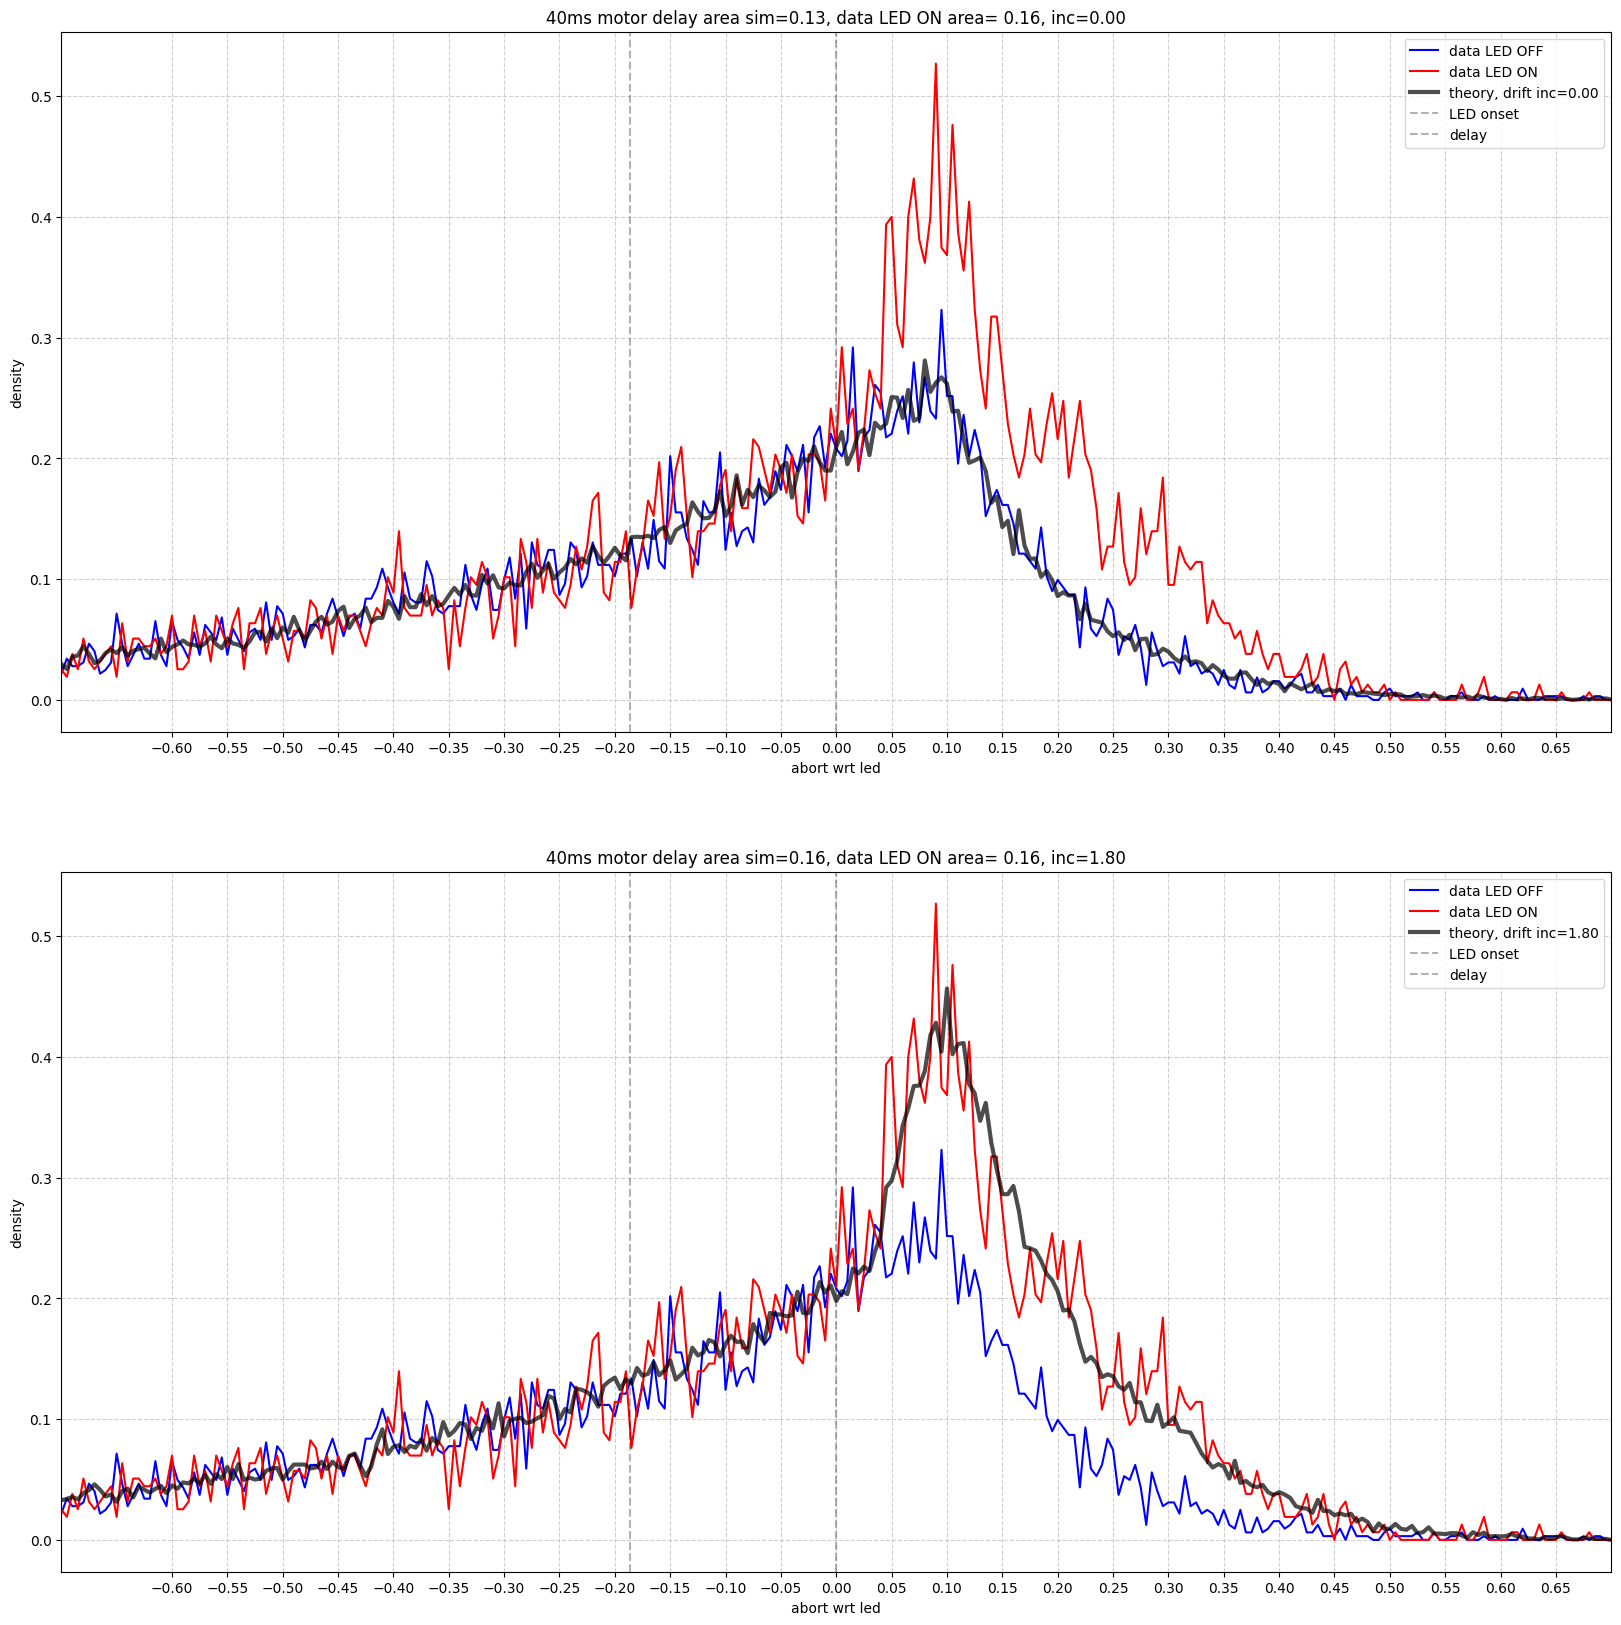

In [16]:
N_sample = int(500e3)
sampled_df = df[['intended_fix', 'LED_onset_time']].sample(n=N_sample, random_state=42, replace=True).reset_index()

sampled_df['t_stim'] = sampled_df['intended_fix']
sampled_df['t_led'] = sampled_df['intended_fix'] - sampled_df['LED_onset_time']

plt.figure(figsize=(20,20))
# theory
time_bin = 0.005; T_max = 1.5
t_pts = np.arange(-2, 2, time_bin)

# data
dt_data = 0.005
t_pts_data = np.arange(-2, 2, dt_data)

### OFF ### 
off_hist, _ = np.histogram(led_off_aborts_wrt_led, bins=t_pts_data, density=True)
off_hist *= (len(led_off_aborts_wrt_led) / len(df[ df['LED_trial'] == 0]))
### ON ###
on_hist, _ = np.histogram(led_on_aborts_wrt_led, bins=t_pts_data, density=True)
on_hist *= (len(led_on_aborts_wrt_led) / len(df[ df['LED_trial'] == 1]))

print(f'base v {base_V_A_mean}, theta {theta_A_mean}, t_aff {t_A_aff_mean}')
steps = [0, 1.8]
f = 1
for step in steps:
    
    new_v = base_V_A_mean + step 

    print(f'new_v {new_v}, base_V_A_mean {base_V_A_mean}')
    sim_res = Parallel(n_jobs=30)(
    delayed(simulate_v_change_pro)(
        {
            'v': base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff': t_A_aff_mean,
            't_led': sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        }
        ) for idx in range(N_sample)
    )

    rts_wrt_led, frac_aborts = filter_sim_res(sim_res)
    print(f'frac_aborts sim {frac_aborts}')
    rts_wrt_led_hist, _ = np.histogram(rts_wrt_led, bins=t_pts, density=True)
    rts_wrt_led_hist *= frac_aborts

    print(f'area under sim {trapz(rts_wrt_led_hist, t_pts[:-1])}')
    print(f'area under data off {trapz(off_hist, t_pts_data[:-1])}')   
    print(f'area under data on {trapz(on_hist, t_pts_data[:-1])}')  

    plt.subplot(len(steps), 1, f)
    # data
    plt.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
    plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')

    # theory
    plt.plot(t_pts[:-1], rts_wrt_led_hist, label=f'theory, drift inc={step:.2f}', lw=3, color='k', alpha=0.7)
    plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
    plt.xlabel('abort wrt led')
    plt.ylabel('density')
    plt.xlim(-0.7, 0.7)
    plt.axvline(t_A_aff_mean, color='k', ls='--', label='delay', alpha=0.3)
    plt.legend()

    # Adding more x-ticks
    xticks = np.arange(-0.6, 0.7, 0.05)  # Customize the number of ticks if needed
    plt.xticks(xticks)

    # Adding grids
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.title(f'40ms motor delay area sim={trapz(rts_wrt_led_hist, t_pts[:-1]):.2f}, data LED ON area= {trapz(on_hist, t_pts_data[:-1]):.2f}, inc={step:.2f}')
    f += 1



In [21]:
def simulate_v_change_pro_v20(sim_params):
    v = sim_params['v']; theta = sim_params['theta']; new_v = sim_params['new_v']; aff = sim_params['aff'] 
    t_led = sim_params['t_led'];
    
    dv = 0
    # t = aff - 0.04      
    t = aff
    while True:
        if t > t_led:
            v = new_v
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv > theta:
            # return t + 0.04, sim_params
            if t < t_led:
                return t + 0, sim_params
            else:
                return t + 0.04, sim_params
        

new_v 3.396381806717504, base_V_A_mean 1.5963818067175037
frac_aborts sim 0.162894
frac_aborts sim 1 0.150294


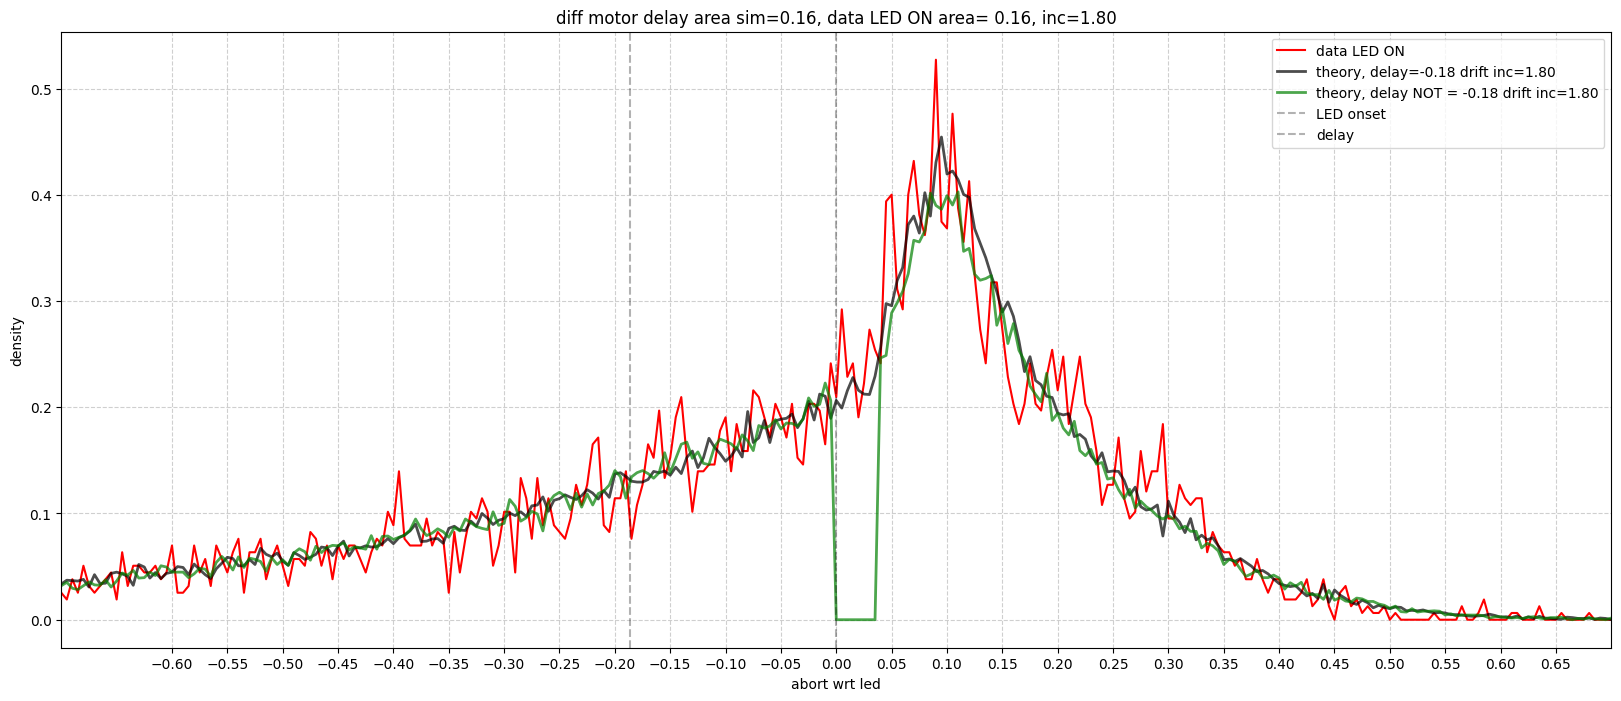

In [22]:
steps = [1.8]
f = 1
plt.figure(figsize=(20,8))
for step in steps:
    
    new_v = base_V_A_mean + step 

    print(f'new_v {new_v}, base_V_A_mean {base_V_A_mean}')
    sim_res = Parallel(n_jobs=30)(
    delayed(simulate_v_change_pro)(
        {
            'v': base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff': t_A_aff_mean,
            't_led': sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        }
        ) for idx in range(N_sample)
    )

    rts_wrt_led, frac_aborts = filter_sim_res(sim_res)
    print(f'frac_aborts sim {frac_aborts}')
    rts_wrt_led_hist, _ = np.histogram(rts_wrt_led, bins=t_pts, density=True)
    rts_wrt_led_hist *= frac_aborts

    sim_res_1 = Parallel(n_jobs=30)(
    delayed(simulate_v_change_pro_v20)(
        {
            'v': base_V_A_mean, 
            'theta': theta_A_mean, 
            'new_v': new_v, 
            'aff': t_A_aff_mean,
            't_led': sampled_df.loc[idx, 't_led'], 
            't_stim': sampled_df.loc[idx, 't_stim']
        }
        ) for idx in range(N_sample)
    )
    rts_wrt_led_1, frac_aborts_1 = filter_sim_res(sim_res_1)
    print(f'frac_aborts sim 1 {frac_aborts_1}')
    rts_wrt_led_hist_1, _ = np.histogram(rts_wrt_led_1, bins=t_pts, density=True)
    rts_wrt_led_hist_1 *= frac_aborts_1


    plt.subplot(len(steps), 1, f)
    # data
    plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')

    # theory
    plt.plot(t_pts[:-1], rts_wrt_led_hist, label=f'theory, delay=-0.18 drift inc={step:.2f}', color='k', alpha=0.7, lw=2)
    plt.plot(t_pts[:-1], rts_wrt_led_hist_1, label=f'theory, delay NOT = -0.18 drift inc={step:.2f}', color='g', alpha=0.7, lw=2)
    plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
    plt.xlabel('abort wrt led')
    plt.ylabel('density')
    plt.xlim(-0.7, 0.7)
    plt.axvline(t_A_aff_mean, color='k', ls='--', label='delay', alpha=0.3)
    plt.legend()

    # Adding more x-ticks
    xticks = np.arange(-0.6, 0.7, 0.05)  # Customize the number of ticks if needed
    plt.xticks(xticks)

    # Adding grids
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.title(f'diff motor delay area sim={trapz(rts_wrt_led_hist, t_pts[:-1]):.2f}, data LED ON area= {trapz(on_hist, t_pts_data[:-1]):.2f}, inc={step:.2f}')
    f += 1



# simulate and see dual peak?

In [10]:
sim_params_2 = { 'v': base_V_A_mean, 'theta': theta_A_mean, 't_led': 0.7, 'new_v': base_V_A_mean + 6}

led_change_sim_2 = Parallel(n_jobs=30)(delayed(simulate_v_change_pro)(sim_params_2) for _ in range(100000))


In [11]:
sim_params_3 = { 'v': base_V_A_mean, 'theta': theta_A_mean, 't_led': 0.7, 'new_v': base_V_A_mean + 10}

led_change_sim_3 = Parallel(n_jobs=30)(delayed(simulate_v_change_pro)(sim_params_3) for _ in range(100000))


In [ ]:
plt.hist(led_change_sim, bins=100, density=True, alpha=0.5, color='b', histtype='step', label=f'new v = {sim_params["new_v"]:.2f}')
plt.hist(led_change_sim_2, bins=100, density=True, alpha=0.5, color='r', histtype='step', label=f'new v = {sim_params_2["new_v"]:.2f}')
plt.hist(led_change_sim_3, bins=100, density=True, alpha=0.5, color='g', histtype='step', label=f'new v = {sim_params_3["new_v"]:.2f}')
plt.axvline(sim_params['t_led'], color='r', ls='--', label='LED onset')
plt.legend()
plt.title(f'motor delay = {motor_delay}')

# compare area ?

In [ ]:
# plt.figure(figsize=(10, 10))
plt.plot(t_pts_data[:-1], off_hist, label='data LED OFF', color='b')
plt.plot(t_pts_data[:-1], on_hist, label='data LED ON', color='r')
dt = 0.1; T_max = 1.5
t_pts = np.arange(0, 2, dt)

trunc_factor_pre_led = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
# steps = np.arange(1, 7, 1)
# steps = [0]
# steps = [0, 1, 4, 6, 8]
steps = [0]

for step in steps:
    new_v = base_V_A_mean + step 
    pdf_n_led_on = np.zeros((N_sample, len(t_pts)))

    for i, (_, row) in enumerate(tqdm(df_sample.iterrows(), total=len(df_sample))):
        t_stim = row['intended_fix']
        t_led = row['intended_fix'] - row['LED_onset_time']

        trunc_factor_post_led = 1 - CDF_rho_times_P_x_t_fn(T_trunc, t_led,  base_V_A_mean, new_v, theta_A_mean, t_A_aff_mean)
        for ti, t in enumerate(t_pts):
            t_prime = t + t_led
            if t_prime <= T_trunc:
                pdf_n_led_on[i, ti] = 0
            else:
                if t_led == 0 and t_prime < t_stim:
                    pdf_n_led_on[i, ti] = rho_A_t_fn(t_prime - t_A_aff_mean, new_v, theta_A_mean) / trunc_factor_pre_led
                elif t_prime > t_stim:
                    pdf_n_led_on[i, ti] = 0
                else:
                    if t <= t_led and t < t_stim:
                        pdf_n_led_on[i, ti] = rho_A_t_fn(t_prime - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_pre_led
                    elif t > t_led and t < t_stim:
                        pdf_n_led_on[i, ti] = PDF_t_v_change(t_prime, t_led, base_V_A_mean, new_v, theta_A_mean, t_A_aff_mean) / trunc_factor_post_led
                    elif t > t_stim:
                        pdf_n_led_on[i, ti] = 0

    
    pdf_n_led_on_mean = np.mean(pdf_n_led_on, axis=0)

    plt.plot(t_pts, pdf_n_led_on_mean, label=f'theory, drift inc={step:.2f}', ls='--', lw=3)


plt.axvline(0, color='k', ls='--', label='LED onset', alpha=0.3)
plt.legend()
plt.xlabel('abort wrt led')
plt.ylabel('density')

print(f'area under data LED on')

# Compare frac of aborts btn led and stim

In [ ]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import sys
def compute_aborts_for_res(row, new_V_A, T_trunc, t_A_aff_mean, base_V_A_mean, theta_A_mean):
    t_led = row['intended_fix'] - row['LED_onset_time']
    t_stim = row['intended_fix']

    if t_led == 0:
        trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, new_V_A, theta_A_mean)
        frac_of_aborts_till_LED = 0

        if T_trunc > t_stim:
            frac_of_aborts_till_stim = 0
        else:
            frac_of_aborts_till_stim = cum_A_t_fn(t_stim - t_A_aff_mean, new_V_A, theta_A_mean) / trunc_factor

        frac_of_aborts_btn_LED_and_stim = frac_of_aborts_till_stim - frac_of_aborts_till_LED
    else:
        trunc_factor_1 = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
        trunc_factor_2 = 1 - CDF_v_change_till_trunc_fn(T_trunc, t_led, base_V_A_mean, new_V_A, theta_A_mean, t_A_aff_mean)

        if t_led < T_trunc < t_stim:
            frac_of_aborts_till_LED = 0
            frac_of_aborts_till_stim = CDF_v_change_till_stim_trunc_adj_fn(t_stim, t_led, base_V_A_mean, new_V_A, theta_A_mean,\
                                                                            t_A_aff_mean, T_trunc, trunc_factor_2)
        elif T_trunc > t_stim:
            frac_of_aborts_till_LED = 0
            frac_of_aborts_till_stim = 0
        else:
            frac_of_aborts_till_LED = cum_A_t_fn(t_led - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_1
            frac_of_aborts_till_stim = CDF_v_change_till_stim_trunc_adj_fn(t_stim, t_led, base_V_A_mean, new_V_A, theta_A_mean,\
                                                                            t_A_aff_mean, T_trunc, trunc_factor_1) # tf 2 -> ` tf1`

        frac_of_aborts_btn_LED_and_stim = frac_of_aborts_till_stim - frac_of_aborts_till_LED
        
    
    return frac_of_aborts_btn_LED_and_stim

# Serial computation over new_V_A_possible
# new_V_A_possible = np.arange(base_V_A_mean, base_V_A_mean + 0.5, 0.05)
new_V_A_possible = np.array([base_V_A_mean])
frac_of_aborts_btn_led_and_stim = np.zeros_like(new_V_A_possible)

df_sample = df.sample(1000)

# sample 1000 rows from df
for idx, new_V_A in enumerate(tqdm(new_V_A_possible, total=len(new_V_A_possible))):
    cdf_led_stim = Parallel(n_jobs=30)(
        delayed(compute_aborts_for_res)(row, new_V_A, T_trunc, t_A_aff_mean, base_V_A_mean, theta_A_mean) 
        for _, row in df_sample.iterrows()
    )
    frac_of_aborts_btn_led_and_stim[idx] = np.mean(cdf_led_stim)


In [ ]:
# from post_LED_censor_utils import PDF_t_v_change
# t_led = 1

# a = CDF_v_change_till_trunc_fn(T_trunc, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean)
# b = cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)

# print(f'a: {a}, b: {b}, {np.abs(a-b)}')

In [ ]:
# from data
num_LED_on = df[ df['LED_trial'] == 1 ].shape[0]    

num_truncated_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] < df['timed_fix']) ]

data_frac =  len(num_truncated_aborts) / num_LED_on
print(f'data frac aborts btn LED and stim = {data_frac}')

In [ ]:
# from data
num_LED_off = len(df[ df['LED_trial'] == 0 ])

num_truncated_aborts_off = df[ (df['LED_trial'] == 0) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] < df['timed_fix']) ]

data_frac_off =  len(num_truncated_aborts_off) / num_LED_off
print(f'data frac aborts btn LED and stim off = {data_frac_off}')

In [ ]:
plt.hist(cdf_led_stim, bins=50, density=True); 
plt.axvline(data_frac, color='r', linestyle='--', label='data')
plt.legend()
plt.xlabel('Fraction of aborts between LED and stim')
plt.ylabel('Density')
plt.title(f'base v = {base_V_A_mean:.2f}, new v = {new_V_A_possible[0]:.2f}, MEAN={np.mean(cdf_led_stim):.2f},true={data_frac:.2f} ')

In [ ]:
def truncated_rho(t,v,a):
    if t  <= T_trunc - t_A_aff_mean:
        return 0
    else:
        return rho_A_t_fn(t,v,a)
    
df_sample = df.sample(10000)
t_pts = np.arange(0, 3, 0.01)
pdf_n = np.zeros((len(df_sample), len(t_pts)))
# rechange idx of df_sample
df_sample = df_sample.reset_index(drop=True)
trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
for rid, row in df_sample.iterrows():
    t_led = row['intended_fix'] - row['LED_onset_time']
    for idx, t in enumerate(t_pts):
        if t <= t_led:
            pdf_n[rid,idx] = truncated_rho(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
        else:
            pdf_n[rid, idx] = 0


In [ ]:
pdf_n_avg = np.mean(pdf_n, axis=0)

In [ ]:
plt.plot(t_pts, pdf_n_avg, label='theoryu')



led_off = df[ (df['LED_trial'] == 0) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] > df['timed_fix']) ]['timed_fix'].values

frac_to_norm = len(led_off) / len(df[ df['LED_trial'] == 0 ])
led_off_hist, _ = np.histogram(led_off, bins=t_pts, density=True)
led_off_hist *= frac_to_norm
print(f'frac to norm: {frac_to_norm}')
plt.plot(t_pts[:-1], led_off_hist, label='LED off')

plt.legend()
plt.title('pre-led, led off aborts')

# btn led and stim

In [ ]:
from post_LED_censor_utils import PDF_t_v_change


df_sample = df.sample(1000)
t_pts = np.arange(0, 3, 0.01)
pdf_n = np.zeros((len(df_sample), len(t_pts)))
# rechange idx of df_sample
df_sample = df_sample.reset_index(drop=True)
# trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
for rid, row in df_sample.iterrows():
    t_led = row['intended_fix'] - row['LED_onset_time']
    t_stim = row['intended_fix']

    for idx, t in enumerate(t_pts):
        if t <= T_trunc:
            pdf_n[rid,idx] = 0
        else:
            if t_led == 0:
                trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
                if t <= t_stim:
                    pdf_n[rid, idx] = rho_A_t_fn(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
                else:
                    pdf_n[rid, idx] = 0
            else:
                trunc_factor_1 = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
                trunc_factor_2 = 1 - CDF_v_change_till_trunc_fn(T_trunc, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean)
                if t <= t_stim:
                    if t <= t_led:
                        pdf_n[rid, idx] = rho_A_t_fn(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_1
                    else:
                        pdf_n[rid, idx] = PDF_t_v_change(t, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean) / trunc_factor_2
                else:
                    pdf_n[rid, idx] = 0

        # if t <= t_led:
        #     pdf_n[rid,idx] = truncated_rho(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
        # if t > t_led and t <= t_stim:
        #     pdf_n[rid, idx] = PDF_t_v_change(t, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean)
        # else:
        #     pdf_n[rid, idx] = 0


In [ ]:
pdf_n_avg = np.mean(pdf_n, axis=0)
t_pts = np.arange(0, 3, 0.01)
led_off = df[ (df['LED_trial'] == 0) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) ]['timed_fix'].values

frac_to_norm = len(led_off) / len(df[ df['LED_trial'] == 0 ])
led_off_hist, _ = np.histogram(led_off, bins=t_pts, density=True)
led_off_hist *= frac_to_norm
print(f'frac to norm: {frac_to_norm}')

plt.plot(t_pts[:-1], led_off_hist, label='data')

plt.plot(t_pts, pdf_n_avg, label='theoryu')

print(f'area under theory curve: {np.trapz(pdf_n_avg, t_pts)}')
print(f'area under data curve: {np.trapz(led_off_hist, t_pts[:-1])}')
plt.legend()
plt.title('LED off aborts,  till t stim')

# Led on pre-led

In [ ]:
df_sample = df.sample(10000)
t_pts = np.arange(0, 3, 0.01)
pdf_n = np.zeros((len(df_sample), len(t_pts)))
# rechange idx of df_sample
df_sample = df_sample.reset_index(drop=True)
trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
for rid, row in df_sample.iterrows():
    t_led = row['intended_fix'] - row['LED_onset_time']
    for idx, t in enumerate(t_pts):
        if t <= t_led:
            pdf_n[rid,idx] = truncated_rho(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
        else:
            pdf_n[rid, idx] = 0

In [ ]:
led_on = df[ (df['LED_trial'] == 1) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] > df['timed_fix']) ]['timed_fix'].values

frac_to_norm = len(led_on) / len(df[ df['LED_trial'] == 1 ])
led_off_hist, _ = np.histogram(led_off, bins=t_pts, density=True)
led_off_hist *= frac_to_norm
print(f'frac to norm: {frac_to_norm}')
plt.plot(t_pts[:-1], led_off_hist, label='LED off')


pdf_on_avg = np.mean(pdf_n, axis=0)
plt.plot(t_pts, pdf_on_avg, label='theoryu')
plt.title('Pre - LED, LED on aborts')

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.scatter(new_V_A_possible, frac_of_aborts_btn_led_and_stim)
plt.axhline(data_frac, color='r', linestyle='--', label='data')
plt.xlabel('new V_A')
plt.ylabel('frac of aborts between LED and stim')

plt.legend();

plt.subplot(1,2,2)
diff = frac_of_aborts_btn_led_and_stim - data_frac
plt.scatter(new_V_A_possible, np.abs(diff))

# close idx to zero in diff
idx = np.argmin(np.abs(diff))
plt.axvline(new_V_A_possible[idx], color='r', linestyle='--', label='new V_A')
plt.axhline(0, color='k', linestyle='--', label='zero diff')
plt.title(f'new V_A = {new_V_A_possible[idx]}')
plt.xlabel('new V_A')
plt.ylabel('abs diff')
plt.legend()